## Description

In this notebook, we estimate the concentrations of lipid ions in pixels of our MS images.  
We use lipid ions detected in Notebook 3.  
We compare the resulting spatial distributions with single ion images of the same lipids (i.e. the spatial distributions of peak intensities of the lipids, taken from unprocessed MS images).   

## Data & modules

In [2]:
%matplotlib notebook

In [3]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
import pandas as pd
from sklearn.cluster import KMeans
from additional_functions import profile_ion_image, centroided_ion_image, segment_average_spectra, analyze_image

In [4]:
import numpy.random as rd

In [5]:
analyzed_mass_range = (700, 900)

In [6]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [7]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

In [8]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [9]:
centroided_images = {'cerebellum': cerebellum_centroided_image, 
                     'bladder': bladder_centroided_image}
profile_images = {'cerebellum': cerebellum_profile_image, 
                  'bladder': bladder_profile_image}
image_shapes = {'cerebellum': cerebellum_image_shape, 
                'bladder': bladder_image_shape}
image_names = ['cerebellum', 'bladder']

In [10]:
lipid_formulas = {n : [] for n in image_names}
for i, n in enumerate(image_names):
    with open(n + '_annotation_results.tsv') as h:
        next(h)  # skipping header
        for l in h:
            l = l.strip().split('\t')
            lipid_formulas[n].append(l[0])
    assert len(lipid_formulas[n]) == len(set(lipid_formulas[n])), 'Formulas for %s are not unique!' % n      
    print('Loaded %i formulas for %s' % (len(lipid_formulas[n]), n))

Loaded 207 formulas for cerebellum
Loaded 180 formulas for bladder


In [11]:
lipid_spectra = {n: [Spectrum(f, adduct='K', threshold=0.05) for f in lipid_formulas[n]] for n in image_names}
for n in image_names:
    for s in lipid_spectra[n]:
        s.normalize()
        assert analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1]

In [12]:
formula_to_class = {}
formula_to_subclass = {}
formula_to_subclass_short = {}
subclass_labeling = {}
with open('selected_lipids_28032022.tsv') as h:
    for l in h:
        l = l.strip().split('\t')
        formula = l[3]
        lipid_class = l[1]
        subclass = l[2]
        subclass_symbol = subclass[(subclass.index('[')+1):subclass.index(']')]
        subclass_labeling[subclass_symbol] = subclass
        try:
            formula_to_subclass[formula].add(subclass)
            formula_to_subclass_short[formula].add(subclass_symbol)
        except KeyError:
            formula_to_subclass[formula] = {subclass}
            formula_to_subclass_short[formula] = {subclass_symbol}
        try:
            formula_to_class[formula].add(subclass)
        except KeyError:
            formula_to_class[formula] = {subclass}
    for f in formula_to_subclass_short:
        formula_to_subclass_short[f] = '/'.join(sorted(formula_to_subclass_short[f]))

In [13]:
test_lipid_names = ['PC(32:0)+K', 'PC(34:1)+K', 'PC(38:4)+K']
test_lipid_formulas = ['C40H80NO8P', 'C42H82NO8P', 'C46H84NO8P']
test_lipid_spectra = [Spectrum(formula=f, adduct='K', threshold=0.05) for f in test_lipid_formulas]
test_lipid_masses = [s.confs[0][0] for s in test_lipid_spectra]
for s in test_lipid_spectra: 
    s.normalize()
    
test_lipid_ids_per_image = {n : [lipid_formulas[n].index(f) for f in test_lipid_formulas] for n in image_names}


## Regression settings

In [22]:
MTD = 0.01
MTD_th = 0.015

## Lipid quantification

Estimation through regression on MS images in centroided mode:

In [23]:
# # Masks for testing purposes - to regress only a part of the image
# masks = {n : np.zeros(image_shapes[n]) for n in image_names}
# masks['cerebellum'][5:15, 20:40] = 1
# masks['bladder'][50:90, 50:100] = 1

In [24]:
regression_images = {}
for n in image_names:
    print('Processing', n)
    start = time()
    regression_images[n] = analyze_image(centroided_images[n], lipid_spectra[n],
                                        # mask=masks[n],
                                         MTD=MTD, MTD_th = MTD_th, MDC=1e-12, MMD=1.,
                                         verbose=False)
    end = time()
    print('Processed', n, 'in', end-start, 'seconds')

Processing cerebellum
Processed cerebellum in 207.88045597076416 seconds
Processing bladder
Processed bladder in 2685.763298511505 seconds


Estimation through monoisotopic peak intensity on MS images in profile mode:  
(note: we use profile mode here because centroid mode can lose hidden peaks; profile mode is more accurate; this is more important for peak-based images than for masserstein-based images).

Note: the cell below uses a slow implementation of ion image generating function - it's not vectorized to process multiple m/z values at once.  

In [25]:
single_peak_images = {n: np.zeros(image_shapes[n] + (len(lipid_spectra[n]), )) for n in image_names}
for n in image_names:
    print('Processing', n)
    start = time()
    for i,s in enumerate(lipid_spectra[n]):
        single_peak_images[n][...,i] = profile_ion_image(profile_images[n], s.confs[0][0])
    end = time()
    print('Processed', n, 'in', end-start, 'seconds')

Processing cerebellum
Processed cerebellum in 12.26843547821045 seconds
Processing bladder
Processed bladder in 122.32043695449829 seconds


Check the results:

<IPython.core.display.Javascript object>


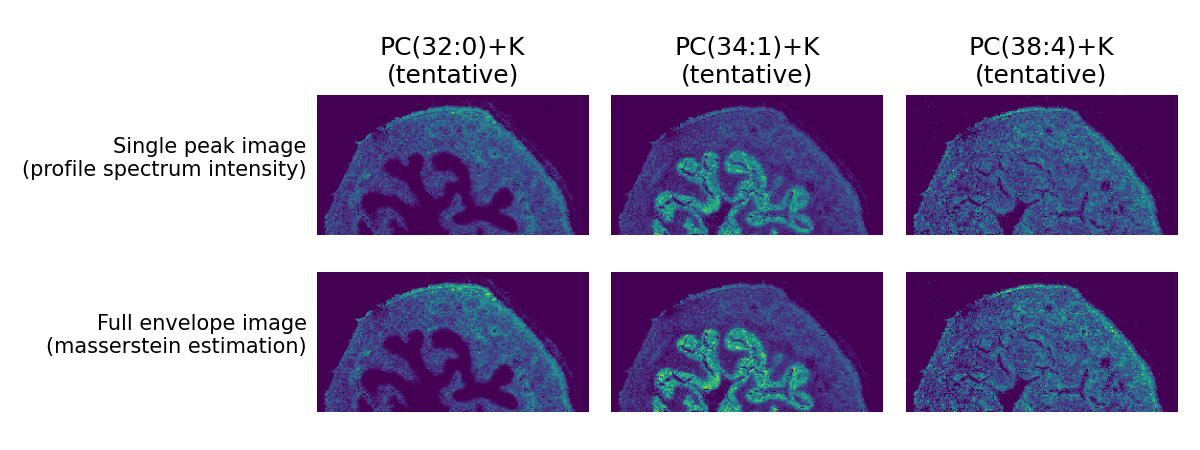

Correlation for PC(32:0)+K 0.9849617562257812
Correlation for PC(34:1)+K 0.9814586503637168
Correlation for PC(38:4)+K 0.9618262247080955


/tmp/ipykernel_724184/4080630301.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 1)
/tmp/ipykernel_724184/4080630301.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 4)
/tmp/ipykernel_724184/4080630301.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 1+i)
/tmp/ipykernel_724184/4080630301.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 4+i)


In [26]:
plt.subplots(2, 4, figsize=(8, 3))
plt.subplot(2, 3, 1)
plt.text(-10, 40, 'Single peak image\n(profile spectrum intensity)',
        ha='right',
        va='top')
plt.subplot(2, 3, 4)
plt.text(-10, 40, 'Full envelope image\n(masserstein estimation)', 
        ha='right',
        va='top')

for i, lipid_id in enumerate(test_lipid_ids_per_image['bladder']):
    test_masserstein = regression_images['bladder'][...,lipid_id]
    test_intensity = single_peak_images['bladder'][...,lipid_id]
    print('Correlation for', test_lipid_names[i], np.corrcoef(test_masserstein.flatten(), test_intensity.flatten())[0,1])
    plt.subplot(2, 3, 1+i)
    plt.title(test_lipid_names[i] + '\n(tentative)')
    plt.imshow(test_intensity)
    plt.axis('off')
    plt.subplot(2, 3, 4+i)
    plt.imshow(test_masserstein)
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/lipid_quantification/bladder_selected_images.png', dpi=300)

In [27]:
np.corrcoef(test_masserstein.flatten(), test_intensity.flatten())

array([[1.        , 0.96182622],
       [0.96182622, 1.        ]])

<IPython.core.display.Javascript object>


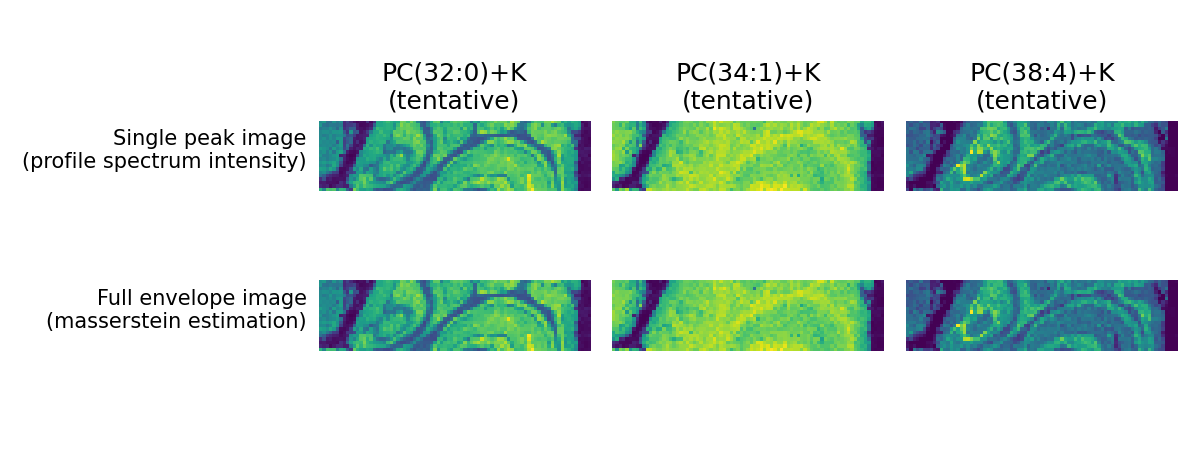

Correlation for PC(32:0)+K 0.9992408154961517
Correlation for PC(34:1)+K 0.998754667175593
Correlation for PC(38:4)+K 0.996156872453959


In [28]:
plt.subplots(2, 3, figsize=(8, 3))
plt.subplot(2, 3, 1)
plt.text(-4, 2, 'Single peak image\n(profile spectrum intensity)',
        ha='right',
        va='top')
plt.subplot(2, 3, 4)
plt.text(-4, 2, 'Full envelope image\n(masserstein estimation)', 
        ha='right',
        va='top')

for i, lipid_id in enumerate(test_lipid_ids_per_image['cerebellum']):
    test_masserstein = regression_images['cerebellum'][...,lipid_id]
    test_intensity = single_peak_images['cerebellum'][...,lipid_id]
    print('Correlation for', test_lipid_names[i], np.corrcoef(test_masserstein.flatten(), test_intensity.flatten())[0,1])
    plt.subplot(2, 3, 1+i)
    plt.title(test_lipid_names[i] + '\n(tentative)')
    plt.imshow(test_intensity)
    plt.axis('off')
    plt.subplot(2, 3, 4+i)
    plt.imshow(test_masserstein)
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/lipid_quantification/cerebellum_selected_images.png', dpi=300)

## Saving the results

Save the estimation results:

In [29]:
regression_images['cerebellum'].dump('cerebellum_regression_images.dmp')
regression_images['bladder'].dump('bladder_regression_images.dmp')

Save the peak intensities:

In [30]:
single_peak_images['cerebellum'].dump('cerebellum_single_peak_images.dmp')
single_peak_images['bladder'].dump('bladder_single_peak_images.dmp')

## Summary of the quantification

Optional: Load the annotations from the previous section, to avoid re-running it

In [14]:
regression_images = {n : np.load(n+'_regression_images.dmp', allow_pickle=True) for n in image_names}
single_peak_images = {n : np.load(n+'_single_peak_images.dmp', allow_pickle=True) for n in image_names}

Visualize example quantifications and compare with single peak intensities:

<IPython.core.display.Javascript object>


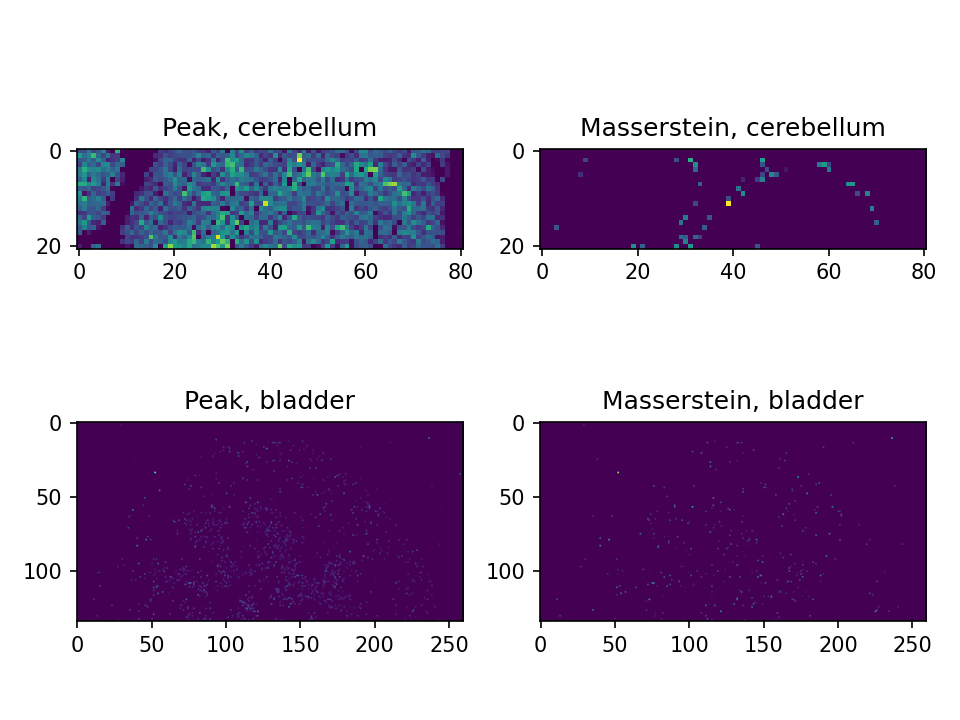

In [15]:
lipid_id = 4

plt.figure()
plt.subplot(221)
plt.title('Peak, cerebellum')
plt.imshow(single_peak_images['cerebellum'][...,lipid_id])
plt.subplot(222)
plt.title('Masserstein, cerebellum')
plt.imshow(regression_images['cerebellum'][...,lipid_id])
plt.subplot(223)
plt.title('Peak, bladder')
plt.imshow(single_peak_images['bladder'][...,lipid_id])
plt.subplot(224)
plt.title('Masserstein, bladder')
plt.imshow(regression_images['bladder'][...,lipid_id])
plt.tight_layout()
plt.show()

Plot the average spectra in the lipid concentration region to verify that the lipid is indeed there:

In [16]:
test_spectrum = lipid_spectra['cerebellum'][lipid_id]
local_mass_axis = np.linspace(test_spectrum.confs[0][0]-10, test_spectrum.confs[0][0]+20, 10001)

In [17]:
cer_mask = single_peak_images['cerebellum'][...,lipid_id] > 0
mask0_spectrum, mask1_spectrum = segment_average_spectra(cerebellum_profile_image, cer_mask, local_mass_axis)          


In [18]:
spectrum_scaling_coef = np.interp(test_spectrum.confs[0][0], 
                                  local_mass_axis,
                                  mask1_spectrum)/(test_spectrum.confs[0][1]*sum(mask1_spectrum))
test_spectrum = test_spectrum*spectrum_scaling_coef

<IPython.core.display.Javascript object>


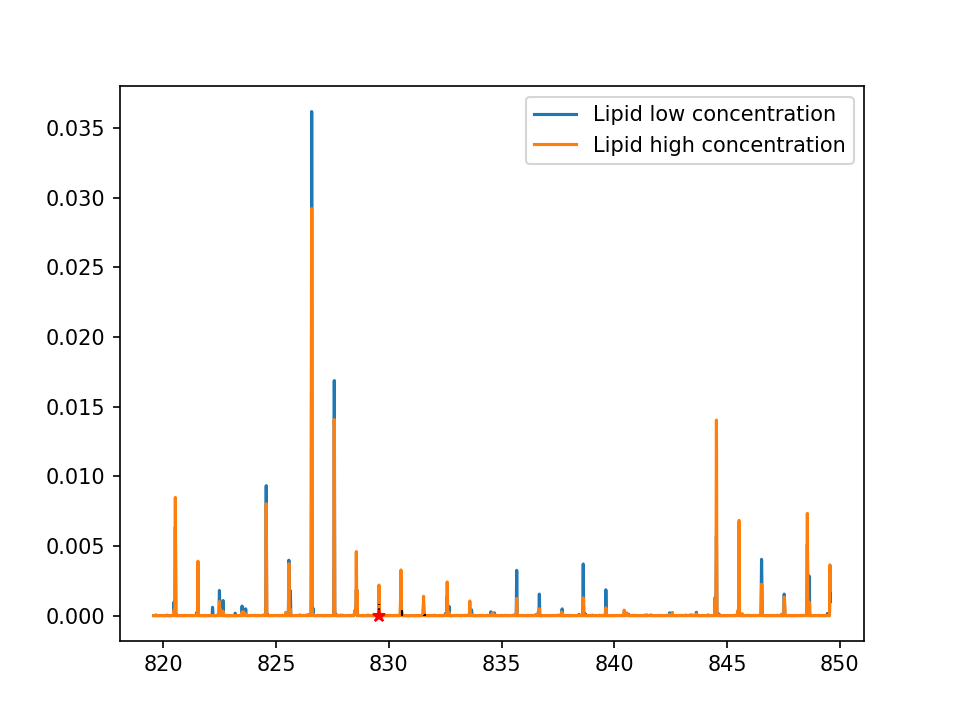

In [19]:
plt.figure()
plt.plot(local_mass_axis, mask0_spectrum/sum(mask0_spectrum))
plt.plot(local_mass_axis, mask1_spectrum/sum(mask1_spectrum))
test_spectrum.plot(ls='--', lw=1, color='k')
plt.plot(test_spectrum.confs[0][0], [0], 'r*')
plt.legend(['Lipid low concentration', 'Lipid high concentration'])

Lipid 0 is indeed present in just a few pixels of the cerebellum.

Check the number of pixels with non-zero proportions per lipid:

In [20]:
nonzero_pixel_count = {n: np.array([np.sum(regression_images[n][...,i]>0) for i in range(regression_images[n].shape[2])]) for n in image_names}

<IPython.core.display.Javascript object>


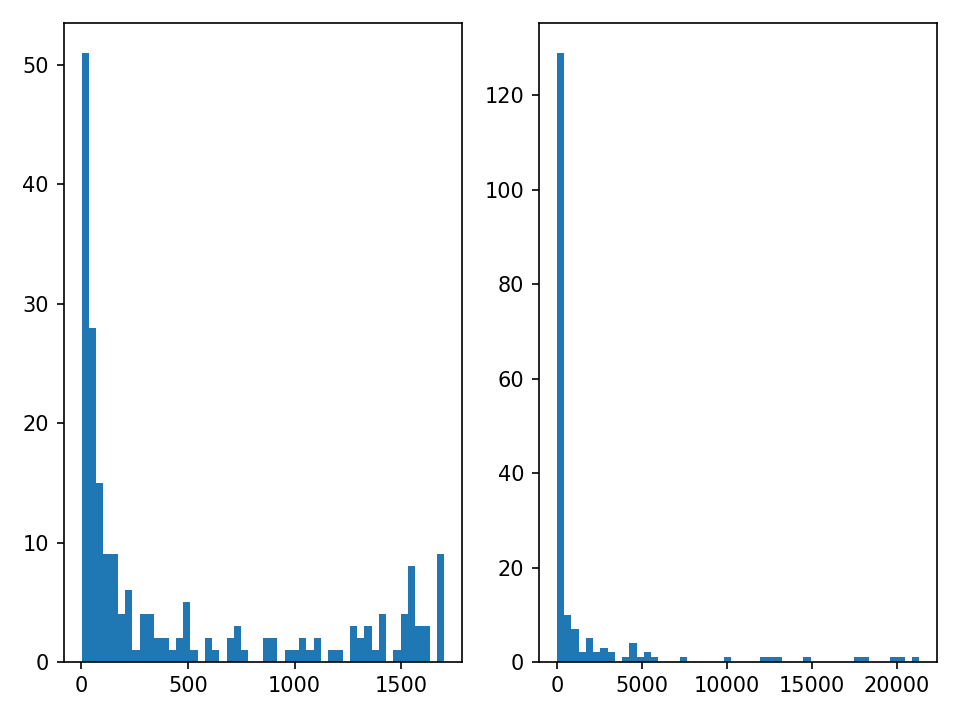

In [21]:
plt.figure()
plt.subplot(121)
plt.hist(nonzero_pixel_count['cerebellum'], bins=50)
plt.subplot(122)
plt.hist(nonzero_pixel_count['bladder'], bins=50)
plt.tight_layout()

Number of "micro-biomarkers" per image:

In [35]:
for n in image_names:
    print('Lipids in >=20\% pixels in', n, ':', sum(nonzero_pixel_count[n]>=0.2*image_shapes[n][0]*image_shapes[n][1]))
    print('Lipids in >=15\% pixels in', n, ':', sum(nonzero_pixel_count[n]>=0.15*image_shapes[n][0]*image_shapes[n][1]))
    print('Lipids in <=1% of pixels in', n, ':', sum(nonzero_pixel_count[n]<=0.01*image_shapes[n][0]*image_shapes[n][1]))

Lipids in >=20\% pixels in cerebellum : 76
Lipids in >=15\% pixels in cerebellum : 85
Lipids in <=1% of pixels in cerebellum : 39
Lipids in >=20\% pixels in bladder : 11
Lipids in >=15\% pixels in bladder : 13
Lipids in <=1% of pixels in bladder : 121


In [63]:
for n in image_names:
    print('Lipids in >=400 pixels in', n, ':', sum(nonzero_pixel_count[n]>=400))
    print('Lipids in >=300 pixels in', n, ':', sum(nonzero_pixel_count[n]>=300))
    print('Lipids in <=10 of pixels in', n, ':', sum(nonzero_pixel_count[n]<=10))

Lipids in >=400 pixels in cerebellum : 74
Lipids in >=300 pixels in cerebellum : 80
Lipids in <=10 of pixels in cerebellum : 25
Lipids in >=400 pixels in bladder : 52
Lipids in >=300 pixels in bladder : 62
Lipids in <=10 of pixels in bladder : 3


Number of "widespread" lipids per image:

In [87]:
for n in image_names:
    print('Lipids in >=50% of pixels in', n, ':', sum(nonzero_pixel_count[n]>=0.5*image_shapes[n][0]*image_shapes[n][1]))

Lipids in >=50% of pixels in cerebellum : 54
Lipids in >=50% of pixels in bladder : 5


Checking the spatial distribution of lipid ions detected in a given percentage of pixels:

In [47]:
perc_low = 0.1
perc_up = 0.15
matching_lipids = {}
for n in image_names:
    image_size = image_shapes[n][0]*image_shapes[n][1]
    lower_pixel_thr = perc_low*image_size
    upper_pixel_thr = perc_up*image_size
    matching_lipids[n] = [i for i,pxc in enumerate(nonzero_pixel_count[n]) if lower_pixel_thr <= pxc <= upper_pixel_thr]
matching_lipids

{'cerebellum': [23, 96, 105, 107, 113, 138, 159, 172, 182, 203],
 'bladder': [10, 28, 45, 65, 88, 130, 156]}

<IPython.core.display.Javascript object>


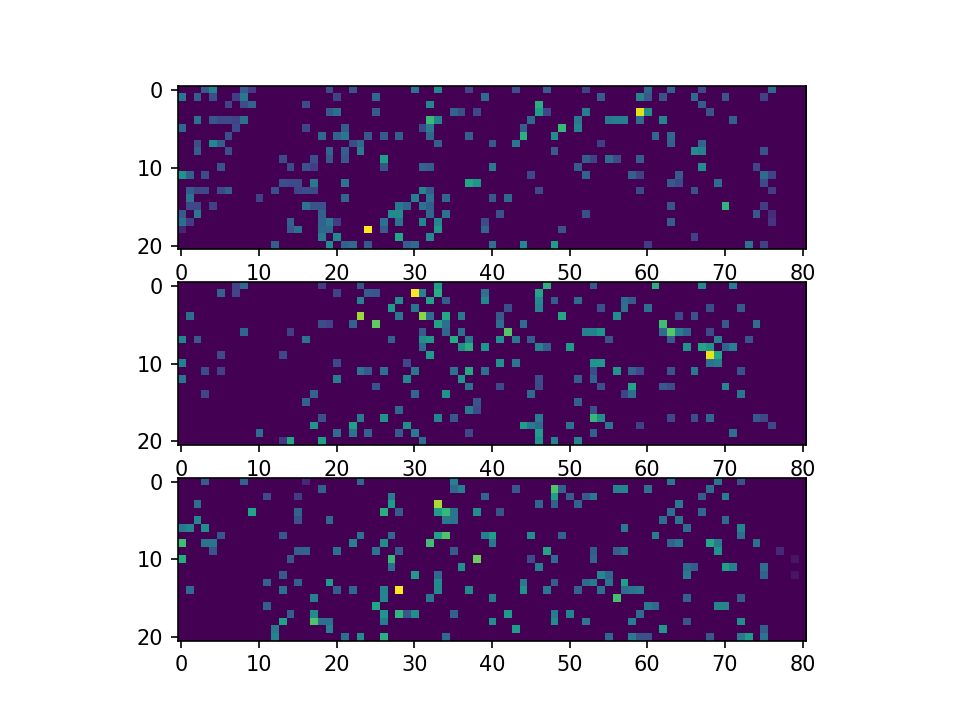

In [39]:
plt.figure()
for i, lid in enumerate(rd.choice(matching_lipids['cerebellum'], 3, replace=False)):
    plt.subplot(311+i)
    plt.imshow(regression_images['cerebellum'][...,lid])

<IPython.core.display.Javascript object>


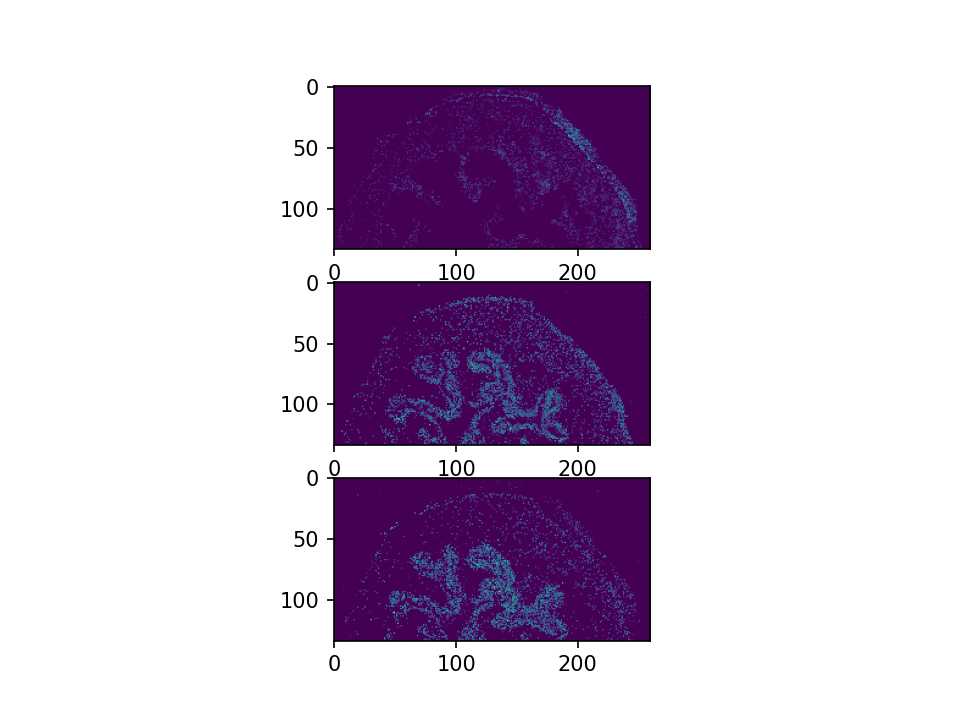

In [40]:
plt.figure()
for i, lid in enumerate(rd.choice(matching_lipids['bladder'], 3, replace=False)):
    plt.subplot(311+i)
    plt.imshow(regression_images['bladder'][...,lid])

As we can see, the percentage of pixels is not a good measure of whether a lipid ion can produce a meaningful segmentation. Therefore, we'll set a threshold of the number of pixels instead.

In [67]:
nb_low = 400
nb_up = 500
matching_lipids = {}
for n in image_names:
    matching_lipids[n] = [i for i,pxc in enumerate(nonzero_pixel_count[n]) if nb_low <= pxc <= nb_up]
matching_lipids

{'cerebellum': [47, 53, 56, 111, 163, 174, 199, 202], 'bladder': [21, 46, 113]}

<IPython.core.display.Javascript object>


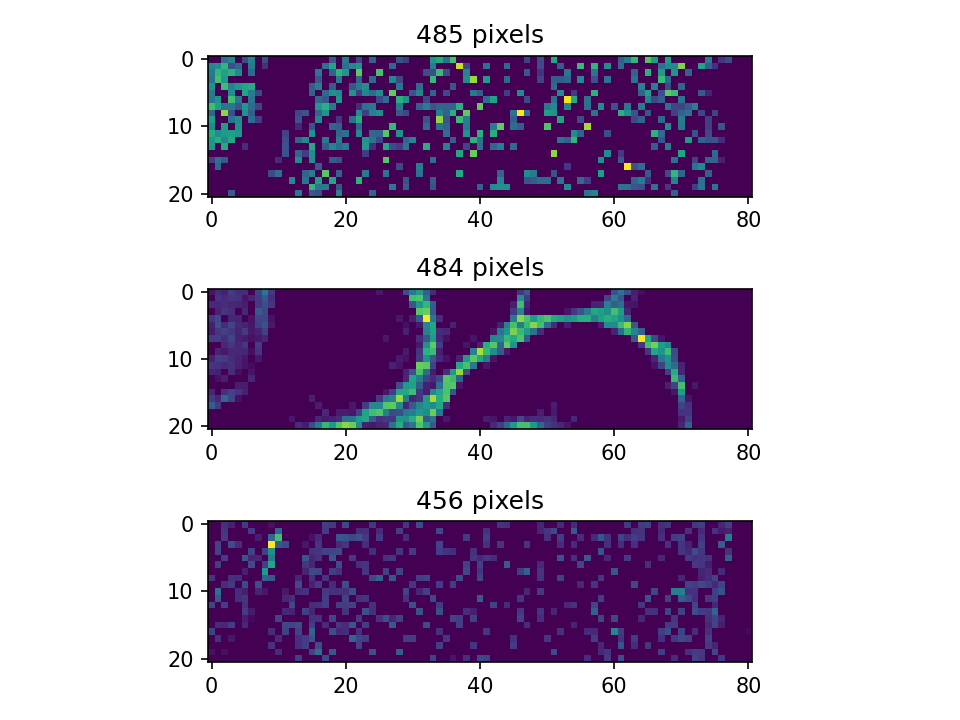

In [68]:
plt.figure()
for i, lid in enumerate(rd.choice(matching_lipids['cerebellum'], 3, replace=False)):
    plt.subplot(311+i)
    plt.title(str(nonzero_pixel_count['cerebellum'][lid]) + ' pixels')
    plt.imshow(regression_images['cerebellum'][...,lid])
plt.tight_layout()

<IPython.core.display.Javascript object>


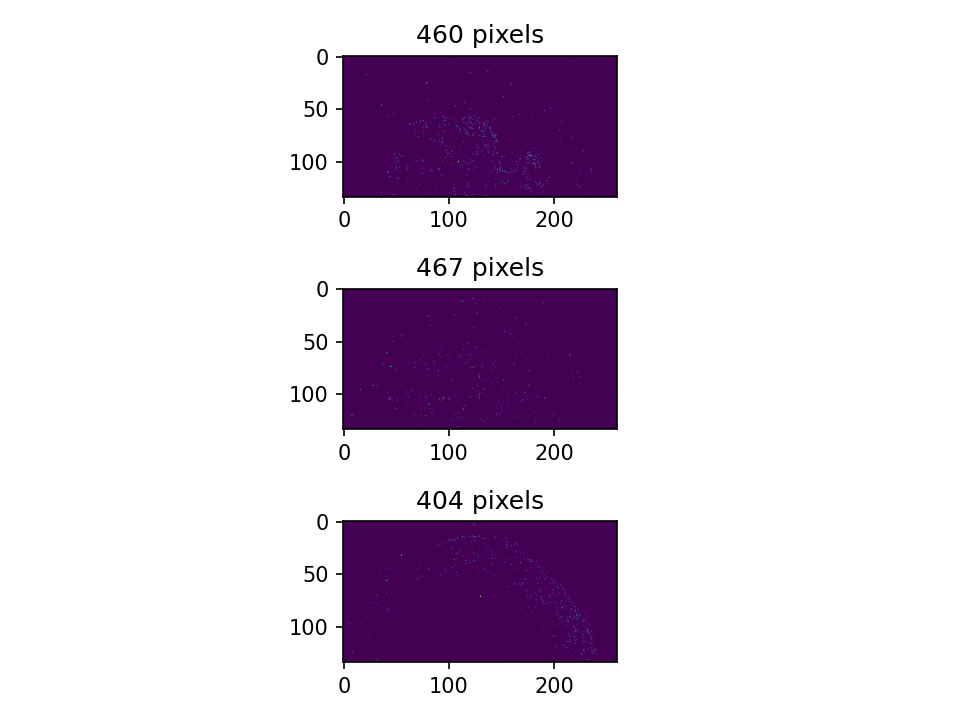

In [69]:
plt.figure()
for i, lid in enumerate(rd.choice(matching_lipids['bladder'], 3, replace=False)):
    plt.subplot(311+i)
    plt.title(str(nonzero_pixel_count['bladder'][lid]) + ' pixels')
    plt.imshow(regression_images['bladder'][...,lid])
plt.tight_layout()

The threshold of 400 pixels seems good enough for both images. 

In [23]:
# lipid_total_signals = {n: np.sum(masserstein_estimation[n], axis=0) for n in image_names}

In [30]:
# annotated_subclasses = {n: [formula_to_subclass[f] for f in lipid_formulas[n]] for n in image_names}

In [54]:
# subclass_total_signals = {n: {} for n in image_names}
# for n in image_names:
#     for i, f in enumerate(lipid_formulas[n]):
#         sbc = formula_to_subclass_short[f]
#         try:
#             subclass_total_signals[n][sbc] += lipid_total_signals[n][i]
#         except KeyError:
#             subclass_total_signals[n][sbc] = lipid_total_signals[n][i]
#     summed_signals = sum(subclass_total_signals[n].values())
#     for sbc in subclass_total_signals[n]:
#         subclass_total_signals[n][sbc] /= summed_signals
#     subclass_total_signals[n] = sorted(subclass_total_signals[n].items(), key=lambda x: x[1], reverse=True)

In [66]:
# subclass_total_signals

{'cerebellum': [('GP01/GP02', 0.5757498532214648),
  ('GP10', 0.26934393307787896),
  ('SP03', 0.08681343818677469),
  ('GP03', 0.03660296926332466),
  ('GP01', 0.01051171891169834),
  ('SP05', 0.009002413380646048),
  ('GP04', 0.007878280792980386),
  ('GP20', 0.0009954729865622829),
  ('GP01/GP02/GP20', 0.0009837252979429598),
  ('GP03/GP20', 0.0009097259673362564),
  ('GP02', 0.0008162262253912177),
  ('SP02', 0.00039224268799928976)],
 'bladder': [('GP01/GP02', 0.6709836160837115),
  ('SP03', 0.25937001879569627),
  ('GP10', 0.04318056400918281),
  ('GP04', 0.012991407495416387),
  ('SP05', 0.005571353810821087),
  ('GP01/GP02/GP20', 0.0035834456407945717),
  ('GP01', 0.0023658928977174044),
  ('GP03', 0.0019537012666599953)]}

In [65]:
# subclass_labeling

{'GP00': 'Other Glycerophospholipids [GP00]',
 'GP01': 'Glycerophosphocholines [GP01]',
 'GP02': 'Glycerophosphoethanolamines [GP02]',
 'GP03': 'Glycerophosphoserines [GP03]',
 'GP04': 'Glycerophosphoglycerols [GP04]',
 'GP05': 'Glycerophosphoglycerophosphates [GP05]',
 'GP06': 'Glycerophosphoinositols [GP06]',
 'GP07': 'Glycerophosphoinositol monophosphates [GP07]',
 'GP08': 'Glycerophosphoinositol bisphosphates [GP08]',
 'GP09': 'Glycerophosphoinositol trisphosphates [GP09]',
 'GP10': 'Glycerophosphates [GP10]',
 'GP11': 'Glyceropyrophosphates [GP11]',
 'GP12': 'Glycerophosphoglycerophosphoglycerols [GP12]',
 'GP13': 'CDP-Glycerols [GP13]',
 'GP14': 'Glycosylglycerophospholipids [GP14]',
 'GP15': 'Glycerophosphoinositolglycans [GP15]',
 'GP16': 'Glycerophosphonocholines [GP16]',
 'GP17': 'Glycerophosphonoethanolamines [GP17]',
 'GP18': 'Di-glycerol tetraether phospholipids (caldarchaeols) [GP18]',
 'GP19': 'Glycerol-nonitol tetraether phospholipids [GP19]',
 'GP20': 'Oxidized glycero

## Verifying the bladder annotation 

In [67]:
# SM34_1 = 'C39H79N2O6P'
# PC32_0 = 'C40H80NO8P'
# PC34_1 = 'C42H82NO8P'
# PC38_4 = 'C46H84NO8P'

In [70]:
# lipid_formulas['bladder'].index(SM34_1)

29

In [71]:
# lipid_total_signals['bladder'][29]

800.6596412730108

In [72]:
# lipid_formulas['bladder'].index(PC32_0)

16

In [73]:
# lipid_total_signals['bladder'][16]

589.8828214646949

In [1]:
# lipid_formulas['bladder'].index(PC34_1)

In [75]:
# lipid_total_signals['bladder'][21]

1099.7496721897598

In [76]:
# lipid_formulas['bladder'].index(PC38_4)

9

In [77]:
# lipid_total_signals['bladder'][9]

510.63573255739675

In [2]:
# selected_images = [np.zeros(image_shapes['bladder']) for _ in range(4)]
# lipids_to_plot = [29, 16, 21, 9]
 
# for i, l in enumerate(masserstein_coordinates['bladder']):
#     for j, lid in enumerate(lipids_to_plot):
#         selected_images[j][l[0], l[1]] = masserstein_estimation['bladder'][i, lid]    
# plt.figure(figsize=(8,3))
# for j, lid in enumerate(lipids_to_plot):
#     plt.subplot(141 + j)
#     plt.title(lid)
#     plt.imshow(selected_images[j])
#     plt.axis('off')
# plt.show()

Deconvolution of selected pixels:

In [2]:
# masserstein_estimation = {n : [] for n in image_names}
# masserstein_coordinates = {n : [] for n in image_names}
# for n in image_names:
#     print('Processing image:', n, '(centroid mode)')
#     s = time()
#     for idx, (xcoord,ycoord,zcoord) in enumerate(centroided_images[n].coordinates):
#         if not idx % 10000:
#             print('Processing pixel number', idx)
#         mz, intsy = centroided_images[n].getspectrum(idx)
#         total_tic = np.sum(intsy)
#         selected_range = (analyzed_mass_range[0] <= mz)*(mz <= analyzed_mass_range[1])
#         mz = mz[selected_range]
#         intsy = intsy[selected_range]
#         local_tic = np.sum(intsy)
# #         selected_peaks = intsy >= 1e-4*max(intsy)
# #         mz = mz[selected_peaks]
# #         intsy = intsy[selected_peaks]
#         pixel_spectrum = Spectrum(confs=list(zip(mz, intsy)))
#         pixel_spectrum.normalize()
#         regression = estimate_proportions(pixel_spectrum, lipid_spectra[n], 
#                                           MTD=MTD, MTD_th=MTD_th, MDC=1e-06, MMD=0.1, progress=False)
#         props = np.array(regression['proportions'])
#         # We want to rescale the proportions so that it's as if they were calculated 
#         # on full spectra (i.e. we correct for restricting spectra to the local mass range)
#         rescaled_props = props*local_tic / total_tic 
#         masserstein_estimation[n].append(rescaled_props)
#         masserstein_coordinates[n].append((ycoord-1, xcoord-1))
#     e = time()
#     print('Regression time:', e-s)
# masserstein_estimation = {n : np.array(masserstein_estimation[n]) for n in image_names}
# masserstein_coordinates = {n : np.array(masserstein_coordinates[n]) for n in image_names}

In [24]:
# intensities = {n : [] for n in image_names}
# intensity_coordinates = {n : [] for n in image_names}
# for n in image_names:
#     print('Processing image:', n, '(profile mode)')
#     monoisotopic_masses = [s.confs[0][0] for s in lipid_spectra[n]]
#     s = time()
#     for idx, (xcoord,ycoord,zcoord) in enumerate(profile_images[n].coordinates):
#         if not idx % 10000:
#             print('Processing pixel number', idx)
#         mz, intsy = profile_images[n].getspectrum(idx)
#         intsy = intsy / np.trapz(intsy, mz)  # note: we normalize BEFORE restricting to local mass range
#         # Restricting is optional in this technique 
#         #selected_range = (analyzed_mass_range[0] <= mz)*(mz <= analyzed_mass_range[1])
#         #mz = mz[selected_range]
#         #intsy = intsy[selected_range]
#         peak_intensities = np.interp(monoisotopic_masses, mz, intsy)
#         intensities[n].append(peak_intensities)
#         intensity_coordinates[n].append((ycoord-1, xcoord-1))
#     e = time()
#     print('Regression time:', e-s)
# intensities = {n : np.array(intensities[n]) for n in image_names}
# intensity_coordinates = {n : np.array(intensity_coordinates[n]) for n in image_names}

Processing image: cerebellum (profile mode)
Processing pixel number 0
Regression time: 0.09274768829345703
Processing image: bladder (profile mode)
Processing pixel number 0
Processing pixel number 10000
Processing pixel number 20000
Processing pixel number 30000
Regression time: 0.9651458263397217


In [ ]:
# test_name = 'bladder'
# test_lipid_id = 25
# test_masserstein = np.zeros(image_shapes[test_name])
# test_intensity = np.zeros(image_shapes[test_name])
# for i, l in enumerate(masserstein_coordinates[test_name]):
#     test_masserstein[l[0], l[1]] = masserstein_estimation[test_name][i, test_lipid_id]
# for i, l in enumerate(intensity_coordinates[test_name]):
#     test_intensity[l[0], l[1]] = intensities[test_name][i, test_lipid_id]
# plt.figure(figsize=(8,3))
# plt.subplot(121)
# plt.axis('off')
# plt.title('Single peak image')
# plt.imshow(test_intensity)
# plt.subplot(122)
# plt.axis('off')
# plt.title('Single lipid image')
# plt.imshow(np.log(0.001+test_masserstein))
# plt.tight_layout()
# plt.show()

In [ ]:
# test_name = 'cerebellum'
# test_lipid_id = 9
# test_masserstein = np.zeros(image_shapes[test_name])
# test_intensity = np.zeros(image_shapes[test_name])
# for i, l in enumerate(masserstein_coordinates[test_name]):
#     test_masserstein[l[0], l[1]] = masserstein_estimation[test_name][i, test_lipid_id]
# for i, l in enumerate(intensity_coordinates[test_name]):
#     test_intensity[l[0], l[1]] = intensities[test_name][i, test_lipid_id]
# plt.figure(figsize=(6,2))
# plt.subplot(121)
# plt.title('Single peak image')
# plt.imshow(test_intensity)
# plt.subplot(122)
# plt.title('Single lipid image')
# plt.imshow(test_masserstein)
# plt.show()

In [126]:
# for n in image_names:
#     frms = lipid_formulas[n]
#     crd = masserstein_coordinates[n]
#     est = masserstein_estimation[n]
#     with open(n + '_masserstein_quantification.tsv', 'w') as h:
#         h.write('X\tY\t' + '\t'.join(frms) + '\n')
#         for i in range(crd.shape[0]):
#             h.write(str(crd[i, 0]) + '\t' + str(crd[i,1]) + '\t' + '\t'.join(list(map(str, est[i]))) + '\n')


NameError: name 'masserstein_coordinates' is not defined

In [ ]:
# for n in image_names:
#     frms = lipid_formulas[n]
#     crd = intensity_coordinates[n]
#     est = intensities[n]
#     with open(n + '_single_peak_intensities.tsv', 'w') as h:
#         h.write('X\tY\t' + '\t'.join(frms) + '\n')
#         for i in range(crd.shape[0]):
#             h.write(str(crd[i, 0]) + '\t' + str(crd[i,1]) + '\t' + '\t'.join(list(map(str, est[i]))) + '\n')


In [ ]:
# for n in image_names:
#     for lipid_id, lipid_sp in enumerate(lipid_spectra[n]):
#         intsy_image = np.zeros(image_shapes[n])
#         decon_image = np.zeros(image_shapes[n])
#         for i, l in enumerate(intensity_coordinates[n]):
#             intsy_image[l[0], l[1]] = intensities[n][i,lipid_id]
#         for i, l in enumerate(masserstein_coordinates[n]):
#             decon_image[l[0], l[1]] = masserstein_estimation[n][i,lipid_id]
        
#         plt.figure()# figsize=(0.1*image_shapes[n][1], 0.1*2*image_shapes[n][0]))
#         plt.subplot(121)
#         plt.title(str(lipid_id) + ' peak at %.2f' % lipid_sp.confs[0][0])
#         plt.imshow(intsy_image)
#         plt.axis('off')
#         plt.subplot(122)
#         plt.title(str(lipid_id) + ' masserstein')
#         plt.imshow(decon_image)
#         plt.axis('off')
#         plt.tight_layout()
#         plt.savefig('Figs/' + n + '_ion_images/%i.png' % lipid_id, dpi=300)
#         plt.close()